In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
from functools import partial
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from scipy.stats import percentileofscore
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# prepare data

In [10]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
outcome_def = 'successful_full_final'
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']


# add preds
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

# sort things
print(f'acc {np.mean((preds > 0) == y):0.3f} vs baseline {1-np.mean(y):0.2f}', )

100%|██████████| 1/1 [00:28<00:00, 28.89s/it]


type <class 'dict'>
acc 0.841 vs baseline 0.65


# viz errs

**figure version**

fracs fp 0.10571124512238382 fn 0.022348350478893223
fn


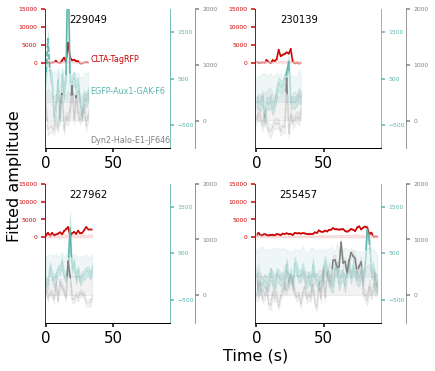

fp


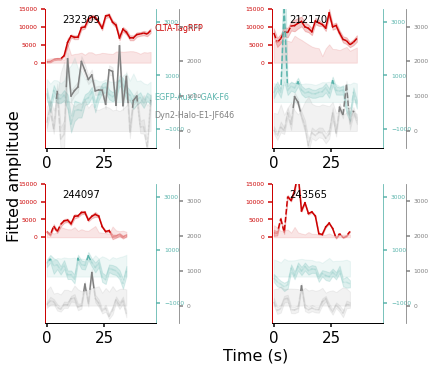

fracs fp 0.10571124512238382 fn 0.022348350478893223
fn


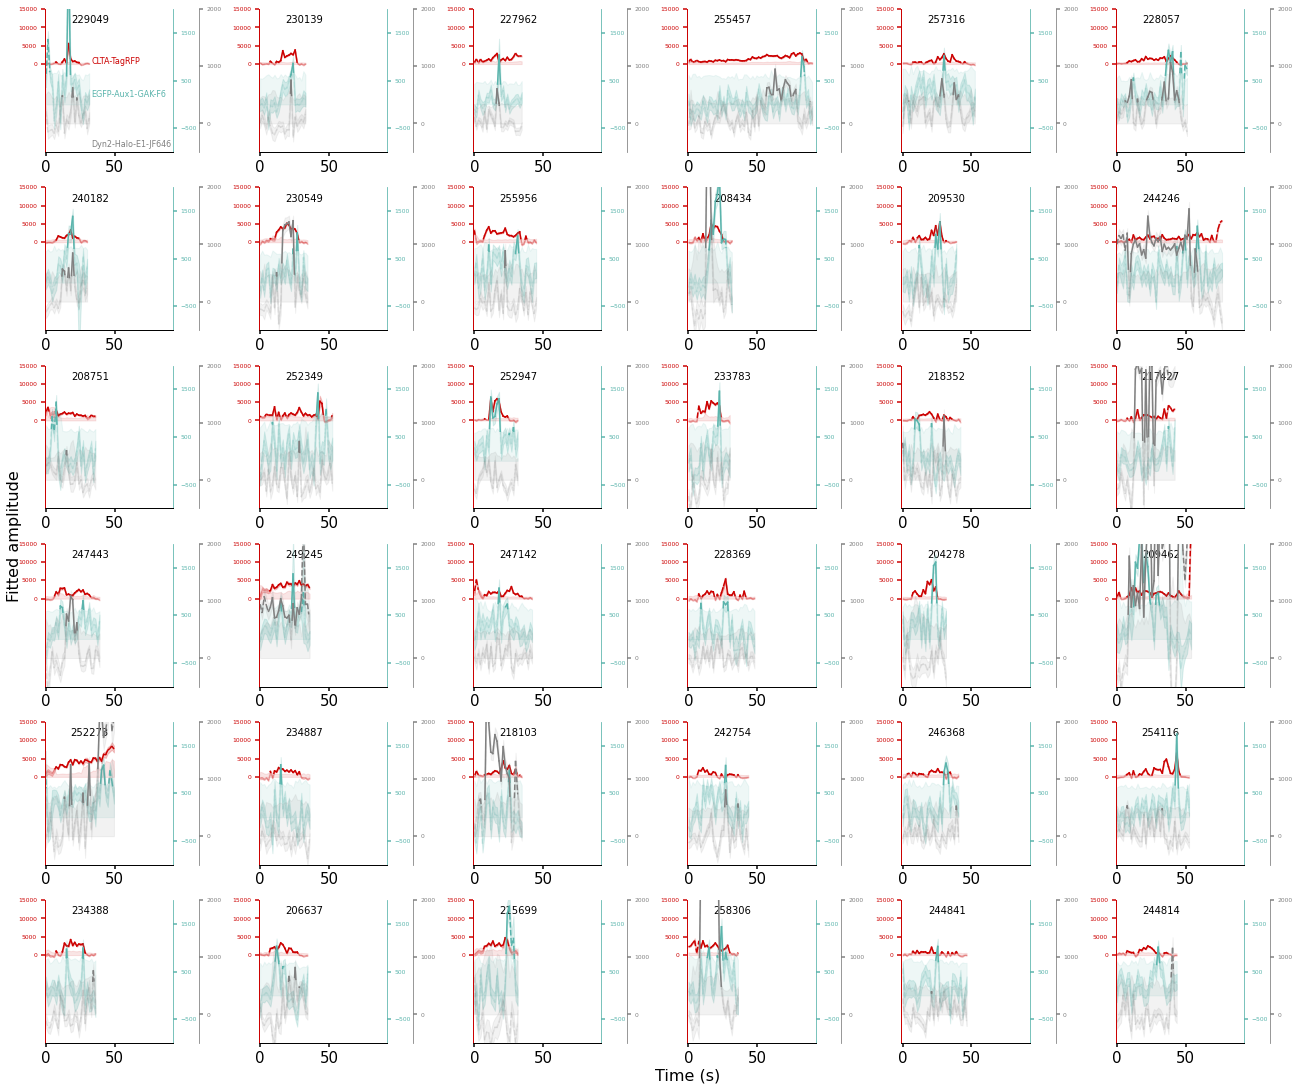

fp


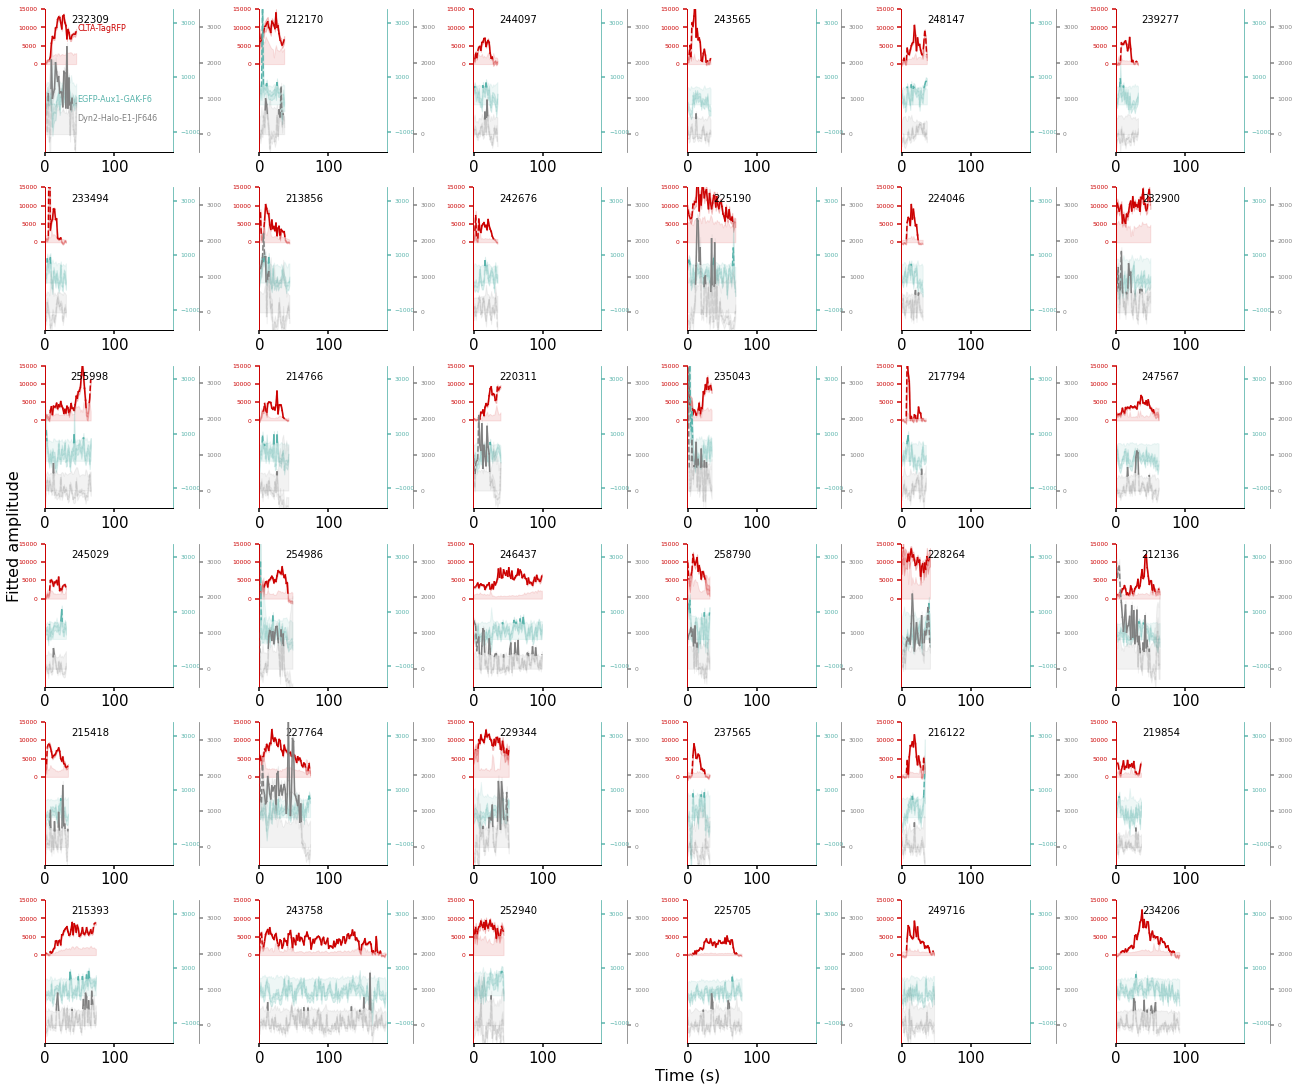

In [11]:
# for figure - note this was switch to show predictions that wre *least* wrong rather than *most* wrong
y = df[outcome_def].astype(bool)
p = df['preds'].values > 0

tp = y & p
tn = ~y & ~p
fp = ~y & p
fn = y & ~p
for setup in ['small', 'big']:
    if setup == 'small':
        R = 2
        C = 2
        text_label_size = 15
        width_mult = 4
    elif setup == 'big':
        R = 6
        C = 6
        text_label_size = 25
        width_mult = 3
    
    print('fracs', 'fp', fp.sum() / y.size, 'fn', fn.sum() / y.size)
    for idxs, name in zip([fn, fp], ['fn', 'fp']):    
        fig = plt.figure(figsize=(C * 3, R * 2.5), facecolor='w')
        
        print(name)
        d = df[idxs]
#         print(d['preds'])
        residuals = np.abs(d[outcome_def] - d['preds'])
        args = np.argsort(residuals.values)[::-1]
#         print(d.shape, args)
        d = d.iloc[args]

        if name == 'fn':
            clathmax = 12000
            auxmax = 2000
        else:
#             clathmax = 16000
            clathmax = 12000
            auxmax = 3500
    
        viz.plot_curves(d, R=R, C=C, hline=False,
                xlim_constant=True,
                ylim_constant=True,
                legend=True,
                extra_key='Z_extended',
                extra_key_label='Dynamin',
                #xlim=(0, 55),
                ylim_cla=(-500, clathmax),
                ylim_aux=(-500, auxmax),
                ylim_dyn=(-500, auxmax),
                yticks=[0, 2000],
                background=True,
                show_track_pid=True,
                #yticklabels=["$0$", "$10^4$"],                
                fig=fig
        )


        # print(errs['pid'].values[:36])
        plt.tight_layout()
        fig.text(0, 0.5, 'Fitted amplitude', va='center', rotation='vertical', fontsize=16)
        fig.text(0.5, 0, 'Time (s)', va='center', fontsize=16)
        
        '''
        for i in range(1, R * C):
            plt.subplot(R, C, i + 1)
            plt.xticks([])
            plt.yticks([])
        '''
        '''
        plt.subplot(R, C, 1 + C * R//2)
        plt.ylabel('Fitted Amplitude')
        plt.subplot(R, C, C * (R - 1) + C//2)
        plt.xlabel('Time')
        '''
    #     plt.tight_layout()
    #     fig.supxlabel('Event duration')

        viz.savefig(f'{name}_{setup}')
        plt.show()

## kymographs

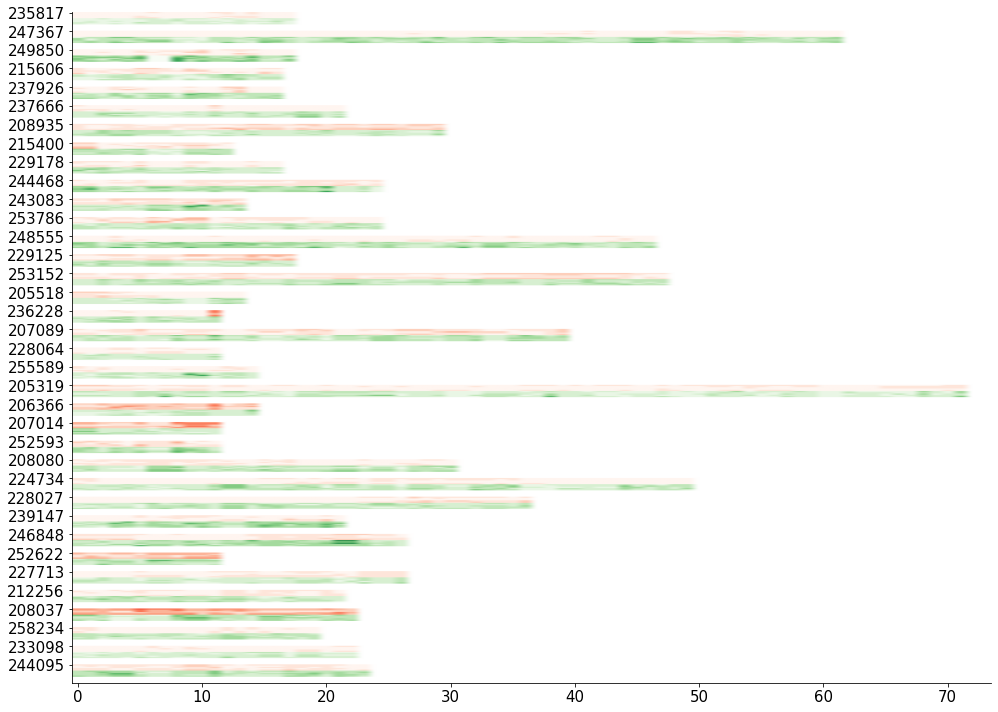

In [39]:
# fps = errs['pid'].values[:36]
tps = df[tp]['pid'].values[:36]
cla_traces, aux_traces, kg = viz.plot_kymographs(df, tps)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(kg, aspect=.1)
plt.yticks(np.arange(0, 3 * 5 * len(tps), 3 * 5), tps)
plt.show()